In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.insert(0, os.path.abspath(".."))
from dotenv import load_dotenv
import seaborn as sns
import pandas as pd
import numpy as np

from db import PostgresDB
from schemas import Proband
from matplotlib import pyplot as plt
from cohorts import Cohort


In [3]:
load_dotenv()


True

In [4]:
db = PostgresDB(
    db_name=os.getenv("DB_NAME"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT"),
    user=os.getenv("DB_USER"),
)


Connected to database


In [5]:
sepsis_query = """
    SELECT sep.subject_id, sta.hadm_id
    FROM mimiciv_derived.sepsis3 sep, mimiciv_icu.icustays sta
    WHERE sep.stay_id = sta.stay_id
    ORDER BY RANDOM()
    LIMIT 200;
"""

kdigo_query = """
    SELECT kdigo.subject_id, sta.hadm_id
    FROM mimiciv_derived.kdigo_stages kdigo, mimiciv_icu.icustays sta
    WHERE kdigo.stay_id = sta.stay_id AND kdigo.aki_stage > 2
    ORDER BY RANDOM()
    LIMIT 200;
"""

meld_query = """
    SELECT meld.subject_id, sta.hadm_id
    FROM mimiciv_derived.meld meld, mimiciv_icu.icustays sta
    WHERE meld.stay_id = sta.stay_id AND meld.meld > 32
    ORDER BY RANDOM()
    LIMIT 200;
"""

cardiac_query = """
    SELECT card.subject_id, card.hadm_id
    FROM mimiciv_derived.cardiac_marker card
    WHERE card.hadm_id IS NOT NULL AND card.ntprobnp > 500
    ORDER BY RANDOM()
    LIMIT 200;
"""


In [6]:
COUNT_PER_GROUP = 30

sepsis_pats = db.execute_query(sepsis_query)
meld_pats = db.execute_query(meld_query)
kdigo_pats = db.execute_query(kdigo_query)
card_pats = db.execute_query(cardiac_query)

groups = [sepsis_pats, card_pats]

participants = []
for group in groups:
    group_participants = []
    count = 0
    for pat in group:
        if pat[0] not in [p.subject_id for p in group_participants] and pat[1] not in [
            p.hadm_id for p in group_participants
        ]:
            group_participants.append(Proband(subject_id=pat[0], hadm_id=pat[1]))
            count += 1
    group_cohort = Cohort(db=db, participants=group_participants)
    group_cohort.initialize_data()
    group_cohort.remove_encounter_with_missing_data()
    participants.extend(
        list(
            [
                Proband(subject_id=e.subject_id, hadm_id=e.hadm_id)
                for e in group_cohort.similarity_encounters
            ][:COUNT_PER_GROUP]
        )
    )


KeyboardInterrupt: 

In [ ]:
cohort = Cohort(participants=participants, db=db)


In [ ]:
cohort.initialize_data(with_tfidf_diagnoses=True)
print(f"encounter before removing: {len(cohort.similarity_encounters)}")
cohort.remove_encounter_with_missing_data()
cohort.similarity_encounters
print(f"encounter after removing: {len(cohort.similarity_encounters)}")
result = cohort.compare_encounters(
    demographics_weight=0.0,
    vitalsigns_weight=0.2,
    diagnoses_weight=0.2,
    labevents_weight=0.6,
    inputevents_weight=0.0,
    aggregate_method="mean",
    normalize_categories=True,
)


encounter before removing: 60
encounter after removing: 60
Finished encounter 21326946
Finished encounter 22400729
Finished encounter 21505994
Finished encounter 27148183
Finished encounter 20170066
Finished encounter 27242451
Finished encounter 22920715
Finished encounter 29728342
Finished encounter 21860723
Finished encounter 24783985
Finished encounter 23646168
Finished encounter 26543049
Finished encounter 21066890
Finished encounter 26148530
Finished encounter 24390802
Finished encounter 23833734
Finished encounter 23977065
Finished encounter 27826225
Finished encounter 25718436
Finished encounter 24148226
Finished encounter 20728952
Finished encounter 22574692
Finished encounter 27592822
Finished encounter 23468952
Finished encounter 26360828
Finished encounter 28210648
Finished encounter 26420020
Finished encounter 26276454
Finished encounter 28542311
Finished encounter 21457723
Finished encounter 27485470
Finished encounter 20729708
Finished encounter 24040691
Finished encounte

In [ ]:
columne_names = [p.hadm_id for p in cohort.participants]
data = [e["similarity"] for e in result]
data = np.array(data).reshape(len(columne_names), len(columne_names))
df = pd.DataFrame(data=data, columns=columne_names, index=columne_names)


In [ ]:
df.shape


(60, 60)

<Axes: >

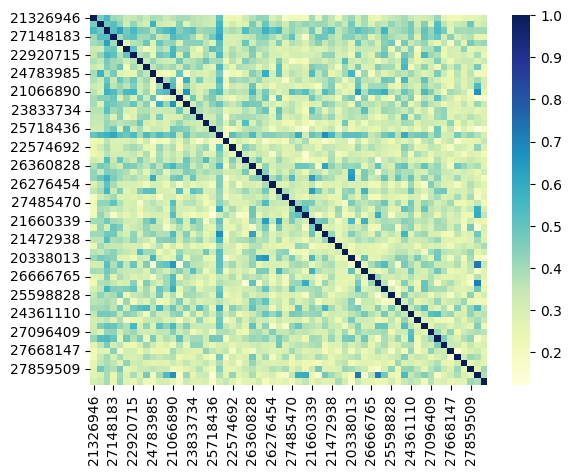

In [ ]:
sns.heatmap(df, cmap="YlGnBu", fmt=".2f")


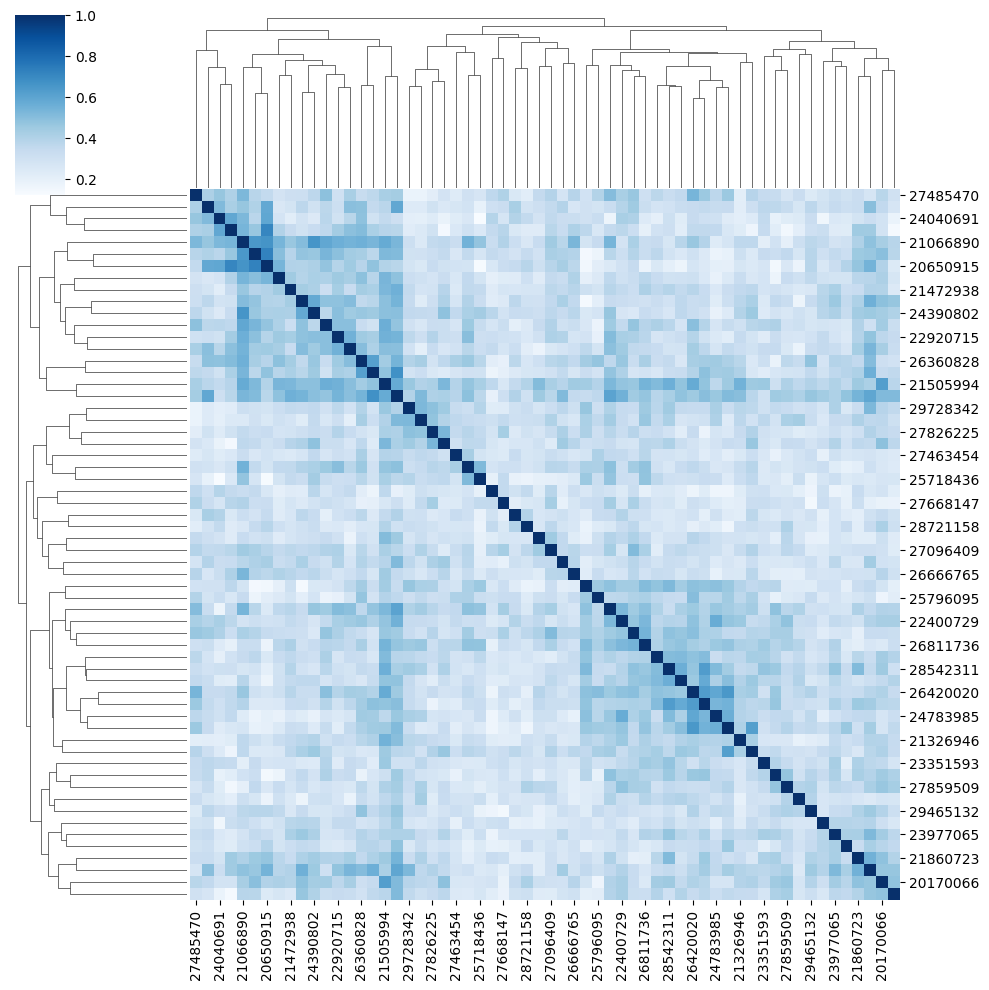

In [ ]:
sns.clustermap(df, annot=False, fmt=".2f", cmap="Blues")


In [ ]:
from sklearn.manifold import MDS


In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation


In [ ]:
meld_encounters = [e[1] for e in meld_pats]
sepsis_encounters = [e[1] for e in sepsis_pats]
# kdigo_pats = [e[1] for e in kdigo_pats]
card_pats = [e[1] for e in card_pats]


In [ ]:
N_CLUSTERS = 4
spectral_cluster = SpectralClustering(
    n_clusters=N_CLUSTERS, affinity="precomputed", n_init=100
).fit(df)
agglomerative_cluster = AgglomerativeClustering(
    n_clusters=N_CLUSTERS, affinity="precomputed", linkage="average"
).fit(df)
kmeans_cluster = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(df)
dbscan_cluster = DBSCAN(eps=0.5, min_samples=2).fit(df)
affinity_cluster = AffinityPropagation().fit(df)

clusters = [
    spectral_cluster,
    agglomerative_cluster,
    kmeans_cluster,
    dbscan_cluster,
    affinity_cluster,
]


/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
for cluster in clusters:
    print(f"Cluster: {cluster.__class__.__name__}")
    print("------------------")
    for index, group in enumerate(groups):
        print(cluster.labels_[index * COUNT_PER_GROUP : (index + 1) * COUNT_PER_GROUP])
    print("\n")


Cluster: SpectralClustering
------------------
[1 2 1 1 0 1 1 1 0 2 0 1 3 2 1 2 0 1 1 0 1 1 0 1 3 1 2 1 2 2]
[3 3 3 2 2 0 1 1 1 2 3 2 1 3 1 0 2 0 2 0 3 1 2 2 1 0 1 0 3 1]


Cluster: AgglomerativeClustering
------------------
[0 0 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Cluster: KMeans
------------------
[0 0 2 0 2 3 2 0 2 0 2 2 2 0 2 0 0 3 3 2 3 3 3 3 2 0 0 3 0 3]
[3 1 1 0 0 2 2 3 3 0 2 0 3 1 2 0 3 2 0 3 2 3 0 0 3 3 3 0 1 3]


Cluster: DBSCAN
------------------
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1]


Cluster: AffinityPropagation
------------------
[ 1  0  0  0  2  0  5  1  7  4  7  5  5  6  5  4  2  1  1  7 10  8  2  1
  7  6  4  8  4  9]
[ 8  3  3  4  9  7  2 10  1  4  5  4  8  3  5  9  6  7  8  2  7  8  0  2
  8  9  6  9  5 10]




/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<Axes: >

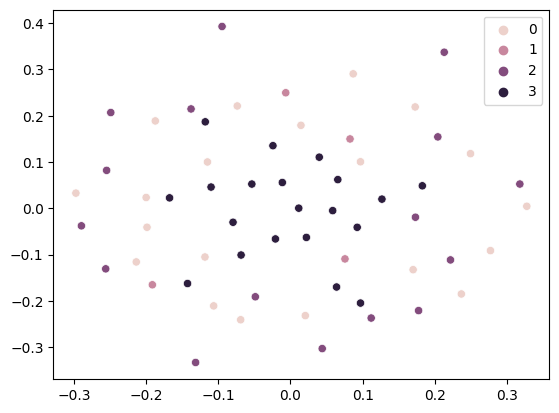

In [ ]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(df)
sns.scatterplot(x=pos[:, 0], y=pos[:, 1], hue=kmeans_cluster.labels_, cmap="Set1")


In [ ]:
# plot the los_hosp and los_icu for each cluster in a different scatterplot
def plot_endpoint_for_cluster(
    participants, cluster, endpoint, x_axis="cluster", hue="cluster", ax=None
):
    y_axis = endpoint
    data = pd.DataFrame(
        {
            x_axis: cluster.labels_,
            y_axis: [getattr(e, endpoint) for e in participants],
            hue: cluster.labels_,
        }
    )
    if ax is None:
        sns.scatterplot(x=x_axis, y=y_axis, hue=hue, data=data, palette="Set1")
    else:
        sns.scatterplot(x=x_axis, y=y_axis, hue=hue, data=data, palette="Set1", ax=ax)


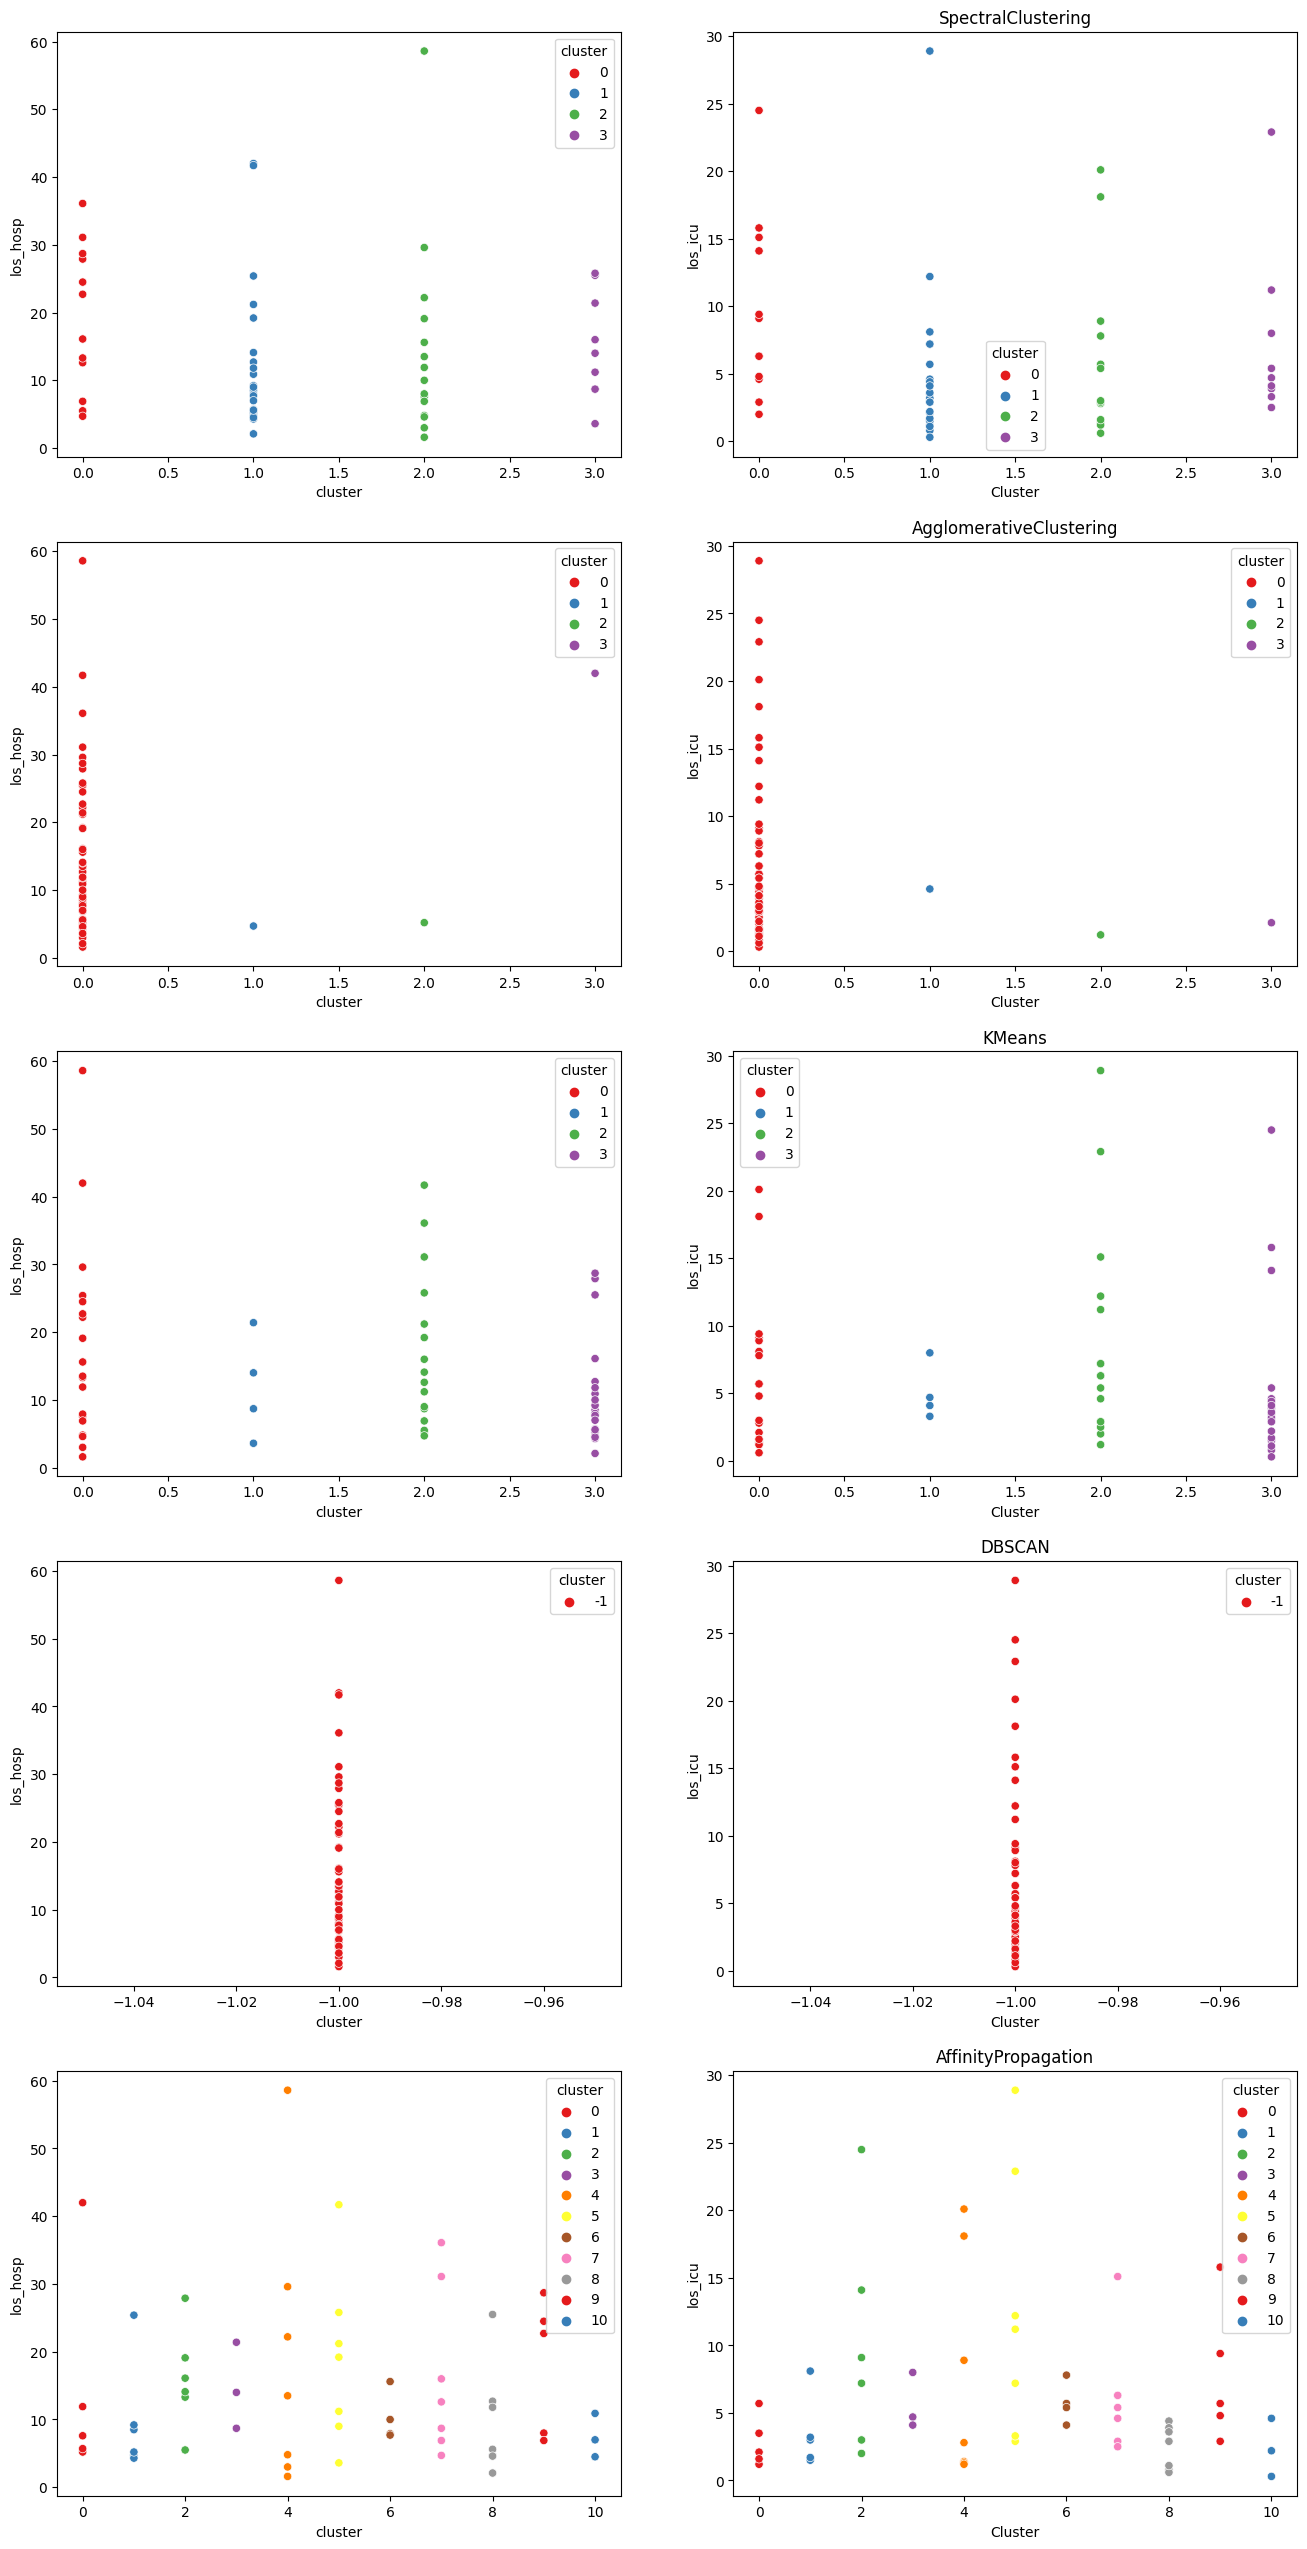

In [ ]:
endpoints = ["los_hosp", "los_icu"]

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=len(clusters), ncols=len(endpoints), figsize=(16, 32))

for col, cluster in enumerate(clusters):
    for row, endpoint in enumerate(endpoints):
        plot_endpoint_for_cluster(
            cohort,
            cluster,
            endpoint,
            x_axis="cluster",
            hue="cluster",
            ax=axes[col][row],
        )
    axes[col][row].set_title(cluster.__class__.__name__)
    axes[col][row].set_xlabel("Cluster")
    axes[col][row].set_ylabel(endpoint)
